In [1]:
import os
import pandas as pd
# import venn
import matplotlib_venn as venn
import itertools as it

# plotting modules
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()
    return

In [3]:
# get combos that contain genes which can cause both high and low bmi
combo2_file = "/data5/deepro/ukbiobank/papers/bmi_project/3_run_rarecomb/white_british/data/parsed_tables/combo_2.csv"
combo3_file = "/data5/deepro/ukbiobank/papers/bmi_project/3_run_rarecomb/white_british/data/parsed_tables/combo_3.csv"

protective_combo2_file = "/data5/deepro/ukbiobank/papers/bmi_project/4_characterization/protective/protective_noicd/data/parsed_tables/combo_2.csv"
protective_combo3_file = "/data5/deepro/ukbiobank/papers/bmi_project/4_characterization/protective/protective_noicd/data/parsed_tables/combo_3.csv"

In [4]:
def parse_combo_df(combo2_file, combo3_file):
    combo2_df = pd.read_csv(combo2_file, usecols=["Phenotype", "Item_1", "Item_2", "Item_1_symbol", "Item_2_symbol", "Case_Samples"])
    combo2_df["Item_3"] = ""
    combo2_df["Item_3_symbol"] = ""
    combo3_df = pd.read_csv(combo3_file, usecols=["Phenotype", "Item_1", "Item_2", "Item_3", "Item_1_symbol", "Item_2_symbol", "Item_3_symbol", "Case_Samples"])
    combo_df = pd.concat((combo2_df, combo3_df))
    return combo_df.loc[:, ["Phenotype", "Item_1", "Item_2", "Item_3", "Item_1_symbol", "Item_2_symbol", "Item_3_symbol", "Case_Samples"]].reset_index(drop=True)

def get_genes_from_df(df):
    geneset = set([g for g in df.loc[:, [f"Item_{i}_symbol" for i in range(1, 4)]].values.flatten() if g])
    return geneset

In [5]:
high_bmi_df = parse_combo_df(combo2_file, combo3_file)
low_bmi_df = parse_combo_df(protective_combo2_file, protective_combo3_file)
high_bmi_genes = get_genes_from_df(high_bmi_df)
low_bmi_genes = get_genes_from_df(low_bmi_df)
both_pheno_genes = high_bmi_genes.intersection(low_bmi_genes)

In [6]:
venn_dict = dict()

def set_add(a, b):
    return a.intersection(b)

def set_subtract(a,b):
    return a.difference(b)

def get_intersecting_genes_num(gene_sets, prod):
    sign = [-1 if p==0 else 1 for p in prod]
    sign_dict = {idx: s for idx,s in zip(range(len(prod)), sign)}
    # get the positive signs first
    sign_dict = dict(sorted(sign_dict.items(), key=lambda item:item[1], reverse=True))
    for i, (k,v) in enumerate(sign_dict.items()):
        if i == 0:
            assert v==1
            final_set = gene_sets[k]
        else:
            if v==-1:
                final_set = set_subtract(final_set, gene_sets[k])
            else:
                assert v==1
                final_set = set_add(final_set, gene_sets[k])
    return len(final_set)

for prod in list(it.product([0, 1], repeat=2)):
    if all(p == 0 for p in prod):
        continue
    else:
        venn_dict["".join(list(map(str, prod)))] = get_intersecting_genes_num([high_bmi_genes,  low_bmi_genes], prod)


In [7]:
venn_dict

{'01': 22, '10': 161, '11': 17}

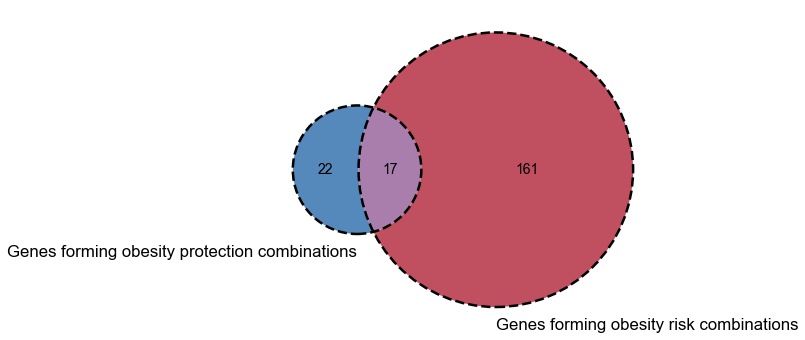

In [8]:
fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")
venn.venn2(subsets=(22, 161, 17), set_labels=["Genes forming obesity protection combinations", "Genes forming obesity risk combinations"], set_colors=("#1e61a5", "#ab162a"), alpha = 0.75, ax=ax)
venn.venn2_circles(subsets = (22, 161, 17), linestyle='dashed', linewidth=2.5, color='k');

In [9]:
save_file = "/data5/deepro/ukbiobank/papers/bmi_project/4_characterization/protective/protective_noicd/data/variably_expressive/genes_overlap.pdf"
save_pdf(save_file, fig)

In [7]:
def get_gene_specific_combo_info(df, gene):
    df = df.loc[(df.Item_1_symbol==gene)|((df.Item_2_symbol==gene))|((df.Item_3_symbol==gene))].reset_index(drop=True)
    return df

def get_case_samples(df):
    high_pheno_cases = ",".join(df.loc[df.Phenotype=="high_bmi"].Case_Samples.str.strip('"').values.flatten()).split(",")
    low_pheno_cases = ",".join(df.loc[df.Phenotype=="low_bmi"].Case_Samples.str.strip('"').values.flatten()).split(",")
    return high_pheno_cases, low_pheno_cases
